# Sequential Learning Project : sequential weighted scheme comparison
_Supervisor : Gilles Stoltz (http://stoltz.perso.math.cnrs.fr/enseignements.html)_

_Author : Hugo Vallet (https://uk.linkedin.com/in/hugovallet)_

_Course : Learning and sequential optimization, Data Science track, Paris-Saclay University_

## Intoduction
In this report, we will test multiple weighting schemes for sequential learning problems. As a reminder, the sequential learning setup is the following :
- We have a set of $N$ "experts", or predictors, $N \in \mathbb{N}$
- We get the data "online", meaning that we do not have access directly to a batch : the examples (data points in $\mathbb{R}^d$) are coming iteratively in time.
- At each step $t$, for a given data point $x_t$, the prediction is a weighted sum of the individual predictions of the  experts. 

The main challenge here is to find the best choice of weights at a time t, given the data (and the associated errors of the experts) seen in the past.

## Dataset
Here, I consider first a toy regression problem generated using the library Sklearn. This dataset is composed of 10000 iid obeservations in $\mathbb{R}^{15}$ following a Gaussian distribution.



In [196]:
#Import libraries
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('hugovallet', '30sc9ihac8')

#Generate the dataset
data,y = make_regression(n_samples = 10000, n_features = 15, n_informative = 15, n_targets = 1 , bias = 0, noise=0.1)

## Choice of experts and methodology
The aim of the report is to study the behaviour of the Ridge-weighting and EWA algorithms on a given set of predictors for an incoming flow of data. Hence, we are not really interested in optimizing the choice of experts. Finally, these experts are fixed at the beginning of the problem : they are not intrinsectly modified during the online process, only their weights are updated.

With this setup, I created a set of random trees that I will use as experts. The trees are generated using a random-forest training approach :

For each tree :
- Select randomly a set of features on which the tree will be trained
- Construct the tree splitting iteratively on a random subset of this features. The split is chosen with a entropy-based criterion : the chosen split is the one maximizing the "information" gain.

I use half of my data for this initial training of the experts and I keep the remaining half for the study of the online weighting algorithms (Ridge and EWA). This approach seems valid in the sens that :
- The datapoints follow the same distribution. Thus, theorically, the experts learnt during the first phase are relevant for the sequential problem.
- Because of the random forest procedure (decribed above) the trees generated are really of variable efficiency. Some of them, which are based on very informative features, perform a lot better than others. Thus, finding a good way to average their predictions (and not taking just the basic average, as used in classical random forest prediction) is relevant.

### First phase : training of the experts (generating the trees)

In [209]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)
reg = RandomForestRegressor(n_estimators=50, max_features='sqrt')
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print "Adjusted R-squared score : ",r2_score(y_pred,y_test)

Adjusted R-squared score :  0.321646503209


When using random forests, it is always interesting to check the features which contribute the most is the model. Sklearn implementation proposes a keys-in-hand method to compute an individual score of the different features which is directly linked to the number of times the features where selected for a split (i.e. how informative they are).

In [210]:
feature_importances = reg.feature_importances_
trace = go.Bar(
         x=[("Feature"+str(i)) for i in range(len(feature_importances))],
         y=feature_importances
)
trace = [trace]
py.iplot(trace, layout=layout, filename='importances')

PlotlyError: Request throttled. You've created/updated more charts than your allowed limit of 50/day. You may either wait one day or upgrade your account. Visit https://plot.ly/settings/subscription/ to upgrade.

From this graph, it is easy to intuit that the trees which are not based on the features 5 and 14, for instance, will be less efficient than the other ones. To check that, let's plot the individual errors of our trees in the random forest.

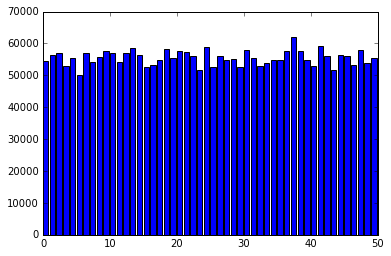

In [219]:
from sklearn.metrics import mean_squared_error
trees = reg.estimators_
errors = []
for tree in trees :
    error = mean_squared_error(y_test,tree.predict(X_test))
    errors.append(error)
    
plt.figure()
plt.bar(np.arange(len(errors)),errors)
plt.show()
    

We can also plot the real value of series to predict and the prediction made by a uniform average of the predictions of the trees 

In [173]:
trace1 = go.Scatter(x = np.arange(len(y_test)),y = y_test,name = "Real value")
trace2 = go.Scatter(x = np.arange(len(y_pred)),y = y_pred, name = "Predicted value")
trace = [trace1, trace2]
py.iplot(trace, filename='prediction VS real value')

In [ ]:
def plot_weights_3d(matrix):
    """
    Note :
    This method is used to create 3D-graphs to plot the errors or weights accross time.
    - matrix : an T by N matrix containing the errors or weights of the N predictors for each iteration between 1 and T.
    """
    T,N = matrix.shape
    data = []
    for n in range(N):
        x = np.ones(T)
        y = np.arange(T)
        z = matrix[:T,n]

        trace = go.Scatter3d(
        x=n*x,
        y=y,
        z=z,
        mode='Markers',
            marker=dict(
                size=12,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.5   
                ),
                opacity=0.8,
                symbol = "circle",
            ),

        )
        data.append(trace)

    layout = go.Layout(
        title = "weights accross time",
        margin=dict(l=0, r=0, b=0, t=5),
        scene=go.Scene(
            xaxis=go.XAxis(title='Expert index'),
            yaxis=go.YAxis(title='Time'),
            zaxis=go.ZAxis(title='Weight')
        )
    )
    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig, filename='simple-3d-scatter')
